In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from random import randint
import time
from time import sleep
from typing import List
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score ,mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr

In [41]:
def sleepms(milliseconds: int):
    seconds = 0.001 * milliseconds
    sleep(seconds)
    
def random_wait():
    start = time.time()
    sleepms(randint(1, 350))

def getFakeUser():
    return {"User-Agent":"PostmanRuntime/7.29.0"}


def getRetHeaders():
    url='https://www.ret.co.il/m/91935/specs'
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    product=soup.find('div',class_='single-product-tab')
    data=product.findAll('ul','list-group list-group-horizontal')
    myheaders= ['מחיר מינימלי','מחיר מקסימלי']
    for alldata in data:
        myheaders.append(alldata.find('span',class_='text-dark font-weight-bold').text.strip())
    return myheaders


def getUrl(url):
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.find('ul', class_='nav nav-pills mb-2 justify-content-around justify-content-md-start col-xxl-10 offset-xxl-1 col-md-12 offset-md-0')
    ref=[]
    data=MainClass.find('a')
    technicalDataPage='https://www.ret.co.il'+data.get('href')
    return technicalDataPage

def getRetData(url):
    technicalDataPage=getUrl(url)
    page = requests.get(technicalDataPage, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    product=soup.find('div',class_='single-product-tab')
    dataLink=product.findAll('ul',class_='list-group list-group-horizontal')
    MinMaxP=MinMaxRetPrices(url)
    mydata=[MinMaxP[0],MinMaxP[1]]
    myheaders=[]
    for alldata in dataLink:
        try:
            mydata.append(alldata.find('li',class_='list-group-item col-8 rounded-0 text-600').text.strip())
        except:
             mydata.append('None')
    return mydata

def MinMaxRetPrices(url):
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.find('div',class_='')
    MainClass=soup.find('div',class_='card-body p-0 p-sm-3')
    price=MainClass.find('div',class_='price')
    if(price==None):
        return [None,None]
    else:
        price=price.text.strip()
        price=price.replace(',','')
        prices=price.split()
        MinPrice=prices[0]
        MaxPrice=prices[3]
        priceArray=MinPrice,MaxPrice
        return priceArray


In [42]:
def getRetToDataFrame(phonesURL):
    hrefLinks=[]
    allRetData=[]
    page = requests.get(phonesURL, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.findAll('a')
    for href in MainClass:
        if('/m/' in href.get('href')):
            hrefLinks.append('https://www.ret.co.il' + href.get('href'))
    for hrefLink in hrefLinks:
        allRetData.append(getRetData(hrefLink))
    return allRetData


In [43]:
def mainFunc(page_num_ret):
    head=getRetHeaders()
    url=f"https://www.ret.co.il/shop/cellphone?pageindex={page_num_ret}"
    data=getRetToDataFrame(url)
    df=pd.DataFrame(data,columns=head)
    return df

In [ ]:
df_ret=mainFunc(1)
for i in range(2,10):
    df_ret=df_ret.append(mainFunc(i))
    random_wait()

In [ ]:
def get_headers():
    url="https://www.zap.co.il/compmodels.aspx?modelid=1142728"
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    All_headers=['מחיר מינימלי','מחיר מקסימלי']
    headers=soup.find_all('div',class_="detailsRow")
    for header in headers:
        All_headers.append(header.find('div',class_="detailsRowTitletxt").text.strip())
    return All_headers


In [ ]:
def get_properites_from_link(url):
    All_data=[]
    All_headers=[]
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    headers=soup.find_all('div',class_="detailsRow")
    titles = ['מחיר מינימלי','מחיר מקסימלי']
    prices = soup.find('div','PricesTxt').findAll('span') 
    if len(prices) == 2:
        All_data = [ prices[1].text, prices[0].text ]
    elif len(prices) == 1: 
        All_data = [ prices[0].text, prices[0].text ]
    else:
        All_data = [ None,None ]
    for header in headers:
        All_headers.append(header.find('div',class_="detailsRowTitletxt").text.strip())
        All_data.append(header.find('div',class_="detailsRowTxt").text.strip())
    return All_data

In [ ]:
def get_data_from_zap(phonesURL):
    hrefLinks=[]
    all_zap_Data=[]
    Main_Url="https://www.zap.co.il"
    page = requests.get(phonesURL, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    links=soup.find_all('div',class_="MoreInfo")
    for link in links:
        hrefLinks.append(Main_Url+(link.find('a')['href']))
    for link in hrefLinks:
        all_zap_Data.append(get_properites_from_link(link))
    return all_zap_Data
    

In [ ]:
def get_details_from_current_page(page_num_zap):
    url="https://www.zap.co.il/models.aspx?sog=e-cellphone&pageinfo={page_num_zap}"
    data=get_data_from_zap(url)
    df=pd.DataFrame(data,columns=get_headers())
    return df


Changing all the headers in the DataFrame from Hebrew to English

In [ ]:

def change_CSV_File_Headers(df):
    df.rename(columns={"פוקוס אוטומטי": "Autofocus"}, inplace=True)
    df.rename(columns={"פלאש": "Flash"}, inplace=True)
    df.rename(columns={"מצלמה": "Camera"}, inplace=True)
    df.rename(columns={"מפעיל": "operator"}, inplace=True)
    df.rename(columns={"דור": "Generation"}, inplace=True)
    df.rename(columns={"סוג רשת": "Network kind"}, inplace=True)
    df.rename(columns={"כרטיס SIM": "SIM"},inplace=True)
    df.rename(columns={"רדיו FM": "FM radio"}, inplace=True)
    df.rename(columns={"גובה": "height"}, inplace=True)
    df.rename(columns={"רוחב": "width"}, inplace=True)
    df.rename(columns={"עובי": "thickness"}, inplace=True)
    df.rename(columns={"משקל": "wheight"}, inplace=True)
    df.rename(columns={"קיבולת סוללה": "Battery capacity"}, inplace=True)
    df.rename(columns={"סוללה נשלפת": "Removable battery"}, inplace=True)
    df.rename(columns={"רמקול חיצוני": "External speaker"}, inplace=True)
    df.rename(columns={"חיבור 3.5": "connection 3.5"},inplace=True)
    df.rename(columns={"מחיר מינימלי": "Minprice"}, inplace=True)
    df.rename(columns={"מחיר מקסימלי": "Maxprice"}, inplace=True)
    df.rename(columns={"יצרן": "Brand"}, inplace=True)
    df.rename(columns={"שנת הכרזה": "Declaration year"}, inplace=True)
    df.rename(columns={"מערכת הפעלה": "Operating System"}, inplace=True)
    df.rename(columns={"סדרה": "series"}, inplace=True)
    df.rename(columns={"מבנה המכשיר": "device structure"},inplace=True)
    df.rename(columns={"ממשק הפעלה": "operating interfaceo"}, inplace=True)
    df.rename(columns={"נפח אחסון פנימי": "Internal storage volume"}, inplace=True)
    df.rename(columns={"ערכת שבבים": "chipset"}, inplace=True)
    df.rename(columns={"צבעים": "colors"}, inplace=True)
    df.rename(columns={"טלפון כשר": "kosher phone"}, inplace=True)
    df.rename(columns={"רמת קרינה (SAR)": "radiation level"}, inplace=True)
    df.rename(columns={"טלפון למבוגרים": "Phone for adults"}, inplace=True)
    df.rename(columns={"מאיץ גרפי": "Graphics accelerator"}, inplace=True)
    df.rename(columns={"מהירות מעבד": "CPU speed"},inplace=True)
    df.rename(columns={"עמידות במים": "Water resistance"}, inplace=True)
    df.rename(columns={"קורא טביעת אצבע": "Fingerprint reader"},inplace=True)
    df.rename(columns={"גודל מסך": "screen size"}, inplace=True)
    df.rename(columns={"סוג מסך": "screen type"}, inplace=True)
    df.rename(columns={"קצב רענון": "refresh rate"}, inplace=True)
    df.rename(columns={"צפיפות פיקסלים": "Pixel density"}, inplace=True)
    df.rename(columns={"מפתח צמצם": "Aperture key"}, inplace=True)
    df.rename(columns={"מעבד": "Processor"}, inplace=True)
    df.rename(columns={"רזולוציה": "resolution"},inplace=True)
    df.rename(columns={"כרטיס זיכרון":"Memory Card"}, inplace=True)
    df.rename(columns={"זיכרון RAM": "RAM memory"}, inplace=True)
    df.rename(columns={"וידאו": "video"}, inplace=True)
    df.rename(columns={"קיבולת הסוללה": "battery capacity"}, inplace=True)
    df.rename(columns={"מספר ליבות": "number of cores"}, inplace=True)
    df.rename(columns={"מצלמה קדמית": "front camera"}, inplace=True)
    df.rename(columns={"טעינה אלחוטית": "wireless charging"}, inplace=True)
    df.to_csv("PhonesDF.csv",index=False)


In [ ]:
df_zap=get_details_from_current_page(1)
for i in range(2,21):
    df_zap=df_zap.append(get_details_from_current_page(i))
    random_wait()

Saving the first DataFrame before cleaning

In [ ]:
def SaveDataFrame(df):
    df=df_zap.append(df_ret)
    df.to_csv('PhonesDF.csv',header=True)
    df=pd.read_csv('PhonesDF.csv')
    change_CSV_File_Headers(df)
    df=pd.read_csv('PhonesDF.csv')
    df


Function to clean all the Data Frame None price columns

In [2]:
def CleanTheDF(df):
    df=df.drop_duplicates()
    df.dropna(axis=0, how='all')
    df=df.dropna(subset=['Minprice','Maxprice'],how ='all')
    df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
    df.to_csv('SmallPhonesDF.csv')
    return df

In [132]:
df=pd.read_csv('PhonesDF.csv')
Smalldf=CleanTheDF(df)

Cleaning the suffix and converting to Numeric

In [133]:
def cleaning_to_numeric(df):
    df['radiation level']=pd.to_numeric(df['radiation level'].str.replace('W/kg','').str.strip(),errors='coerce')
    df['height']=pd.to_numeric(df['height'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['Internal storage volume']=pd.to_numeric(df['Internal storage volume'].str.replace('GB','').str.replace('1TB','1000').str.strip(),errors='coerce')
    df['RAM memory']=pd.to_numeric(df['RAM memory'].str.replace('GB','').str.strip(),errors='coerce')
    df['width']=pd.to_numeric(df['width'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['thickness']=pd.to_numeric(df['thickness'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['wheight']=pd.to_numeric(df['wheight'].str.replace('גרם','').str.strip(),errors='coerce')
    df['refresh rate']=pd.to_numeric(df['refresh rate'].str.replace('Hz','').str.strip(),errors='coerce')
    df['Pixel density']=pd.to_numeric(df['Pixel density'].str.replace('ppi','').str.strip(),errors='coerce')
    df['number of cores']=df['number of cores'].apply(lambda x: x.removesuffix(' ליבות') if x else None) 
    df['screen size']=pd.to_numeric(df['screen size'].str.replace('אינטש','').str.strip(),errors='coerce')
    df['Network kind']=pd.to_numeric(df['Network kind'].str.replace('G','').str.strip(),errors='coerce')
    df['front camera']=pd.to_numeric(df['front camera'].str.replace('מגה פיקסל','').str.strip(),errors='coerce')
    df['Flash']=pd.to_numeric(df['Flash'].str.replace('לדים','').str.strip(),errors='coerce')
    df['resolution']=df['resolution'].apply(lambda x: x.removesuffix(' פיקסלים'))
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' מגה פיקסל') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' מגה פיקסלים') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' צגה פיקסל') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' גה פיקסל') if x else None)
    df['CPU speed']=df['CPU speed'].apply(lambda x: x.split()[0] if x else None)
    df['battery capacity']=df['battery capacity'].apply(lambda x: x.removesuffix(' mAh')if x else None)
    df['battery capacity']=pd.to_numeric(df['battery capacity'].str.replace(',','').str.strip(),errors='coerce') 
    df['Minprice']=pd.to_numeric(df['Minprice'].str.replace(',','').str.strip(),errors='coerce')
    df['Maxprice']=pd.to_numeric(df['Maxprice'].str.replace(',','').str.strip(),errors='coerce')
    return df



In [134]:
df_WithNone = Smalldf.copy()
for col in df_WithNone:
    df_WithNone.loc[(df_WithNone[col] == 'לא זמין') |(df_WithNone[col] == 'יעודכן בקרוב'),col]=None
df_WithNone=cleaning_to_numeric(df_WithNone)
df_WithNone["Autofocus"] =  np.where(df_WithNone['Autofocus']  == "כולל" , 1 , 0)
df_WithNone["connection 3.5"] =  np.where(df_WithNone['connection 3.5']  == "ללא" , 0 , 1)
df_WithNone["Dual-SIM"] =  np.where(df_WithNone['Dual-SIM']  == "ללא" , 0 , 1)
df_WithNone["Memory Card"] =  np.where(df_WithNone['Memory Card']  == "ללא" , 0 , 1)
df_WithNone["Fingerprint reader"] =  np.where(df_WithNone['Fingerprint reader']  == "ללא" , 0 , 1)
df_WithNone["WiFi"] =  np.where(df_WithNone['WiFi']  == "כולל" , 1 , 0)
df_WithNone["IR"] =  np.where(df_WithNone['IR']  == "לא כולל" , 0 , 1)
df_WithNone["GPS"] =  np.where(df_WithNone['GPS']  == "כולל" , 1 , 0)
df_WithNone["NFC"] =  np.where(df_WithNone['NFC']  == "כולל" , 1 , 0)
df_WithNone["FM radio"] =  np.where(df_WithNone['FM radio']  == "ללא רדיו" , 0 , 1)
df_WithNone["Removable battery"] =  np.where(df_WithNone['Removable battery']  == "לא" , 0 , 1)
df_WithNone["External speaker"] =  np.where(df_WithNone['External speaker']  == "ללא" , 0 , 1)
df_WithNone["kosher phone"] =  np.where(df_WithNone['kosher phone']  == "טלפון כשר" , 1, 0)
df_WithNone["colors"] = np.where( df_WithNone['colors']!= None, 1, 0)
df_WithNone["Smartphone"] = np.where( df_WithNone['Smartphone']== "סמארטפון", 1, 0)
df_WithNone["operating interfaceo"] = np.where( df_WithNone['operating interfaceo']!= 'None', 1, 0)
df_WithNone["device structure"] = np.where( df_WithNone['device structure']== "פאבלט", 1, 0)
df_WithNone["wireless charging"] =  np.where(df_WithNone['wireless charging']  == "כולל" , 1 , 0)
df_WithNone["Bluetooth"] =  np.where(df_WithNone['Bluetooth']  != 'None' , 1 , 0)
df_WithNone["Phone for adults"] =  np.where(df_WithNone['Phone for adults'] =='טלפון למבוגרים' , 1,0)


for i in df_WithNone.index:
    try:
        df_WithNone['number of cores'][i]=eval(df_WithNone['number of cores'][i])
    except:
        df_WithNone['number of cores'][i]=None
for i in df_WithNone.index:
    try:
        df_WithNone['Camera'][i]=eval(df_WithNone['Camera'][i])
    except:
        df_WithNone['Camera'][i]=None
for i in df_WithNone.index:
        try:
            df_WithNone['resolution'][i]=eval(df_WithNone['resolution'][i].replace('x','*'))
        except: 
            if df_WithNone['resolution'][i]!= None:
                a = df_WithNone['resolution'][i].split('x')
                b = a[1].split('\u200f')
                df_WithNone['resolution'][i]=(int(a[0])*int(b[0]))


    

C:\Users\eranb\AppData\Local\Temp\ipykernel_14196\1443733727.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_WithNone['number of cores'][i]=eval(df_WithNone['number of cores'][i])
C:\Users\eranb\AppData\Local\Temp\ipykernel_14196\1443733727.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_WithNone['number of cores'][i]=None
C:\Users\eranb\AppData\Local\Temp\ipykernel_14196\1443733727.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

After using the pd.to_numeric all the values that werent changed got changed into NAN values and we also saw that we good 'None' values as a string insted of None this rows change them back to None

In [135]:
df_WithNone=df_WithNone.replace('None',np.nan)
df_WithNone=df_WithNone.replace({None:np.nan})
df_WithNone = df_WithNone.replace({'ללא': 'Without'})
df_WithNone = df_WithNone.replace({'כולל': 'Included'})
df_WithNone = df_WithNone.replace({'SIM אחד , eSIM': 'eSIM'})
df_WithNone = df_WithNone.replace({'Dual SIM אופציונלי': 'Optional Dual SIM'})


In [136]:
def to_numeric_second_time(df,cols):
    for col in cols:
        df[col]=pd.to_numeric(df[col])
    return df

In [137]:
listThatShouldBe=['Declaration year','CPU speed','Generation']
df_WithNone=to_numeric_second_time(df_WithNone,listThatShouldBe)

First of all lets merge between the min price and max price columns to an avg column.

In [138]:
dfUnionPrice=df_WithNone.copy()
dfUnionPrice['Price']=(dfUnionPrice['Minprice'] + dfUnionPrice['Maxprice'])/2
dfUnionPrice=dfUnionPrice.drop(['Minprice','Maxprice'],axis=1)
dfUnionPrice.describe()

,Declaration year,device structure,Smartphone,radiation level,operating interfaceo,kosher phone,colors,Phone for adults,Internal storage volume,number of cores,...,FM radio,height,width,thickness,wheight,battery capacity,Removable battery,wireless charging,Dual-SIM,Price
count,310.000000,429.000000,429.000000,127.000000,429.000000,429.000000,429.0,429.000000,388.000000,298.000000,...,429.000000,378.000000,392.000000,398.000000,398.000000,347.000000,429.000000,429.000000,429.000000,429.000000
mean,2019.561290,0.811189,0.890443,0.698228,0.962704,0.020979,1.0,0.037296,156.144330,7.604027,...,0.426573,155.932540,73.401786,8.654749,183.820352,4110.458213,0.104895,0.370629,0.752914,1894.544289
std,2.187294,0.391815,0.312702,0.376060,0.189707,0.143481,0.0,0.189707,98.542032,1.109001,...,0.495157,13.239346,7.871352,2.745878,30.772489,1158.255560,0.306776,0.483537,0.431821,1399.096567
min,2007.000000,0.000000,0.000000,0.220000,0.000000,0.000000,1.0,0.000000,4.000000,2.000000,...,0.000000,76.000000,44.700000,6.400000,70.200000,430.000000,0.000000,0.000000,0.000000,108.000000
25%,2019.000000,1.000000,1.000000,0.360000,1.000000,0.000000,1.0,0.000000,128.000000,8.000000,...,0.000000,151.700000,71.725000,7.800000,174.250000,3700.000000,0.000000,0.000000,1.000000,849.500000
50%,2020.000000,1.000000,1.000000,0.590000,1.000000,0.000000,1.0,0.000000,128.000000,8.000000,...,0.000000,160.200000,74.800000,8.200000,189.000000,4500.000000,0.000000,0.000000,1.000000,1494.000000
75%,2021.000000,1.000000,1.000000,0.990000,1.000000,0.000000,1.0,0.000000,256.000000,8.000000,...,1.000000,163.700000,76.100000,8.800000,199.000000,5000.000000,0.000000,1.000000,1.000000,2563.000000
max,2022.000000,1.000000,1.000000,1.630000,1.000000,1.000000,1.0,1.000000,512.000000,10.000000,...,1.000000,192.700000,128.200000,54.000000,282.000000,6000.000000,1.000000,1.000000,1.000000,7850.000000


In [139]:
def getNumericalsCatagoricals(df):
    Numericals=df.describe().columns
    all_cols=df.columns
    Catagoricals=[]
    for col in all_cols:
        if(col not in Numericals):
            Catagoricals.append(col)
    return Numericals,Catagoricals

In [140]:
Numericals,Categoricals=getNumericalsCatagoricals(dfUnionPrice)
print('Numericals ammount:' ,len(Numericals) ,'\n Catagoricals ammount:' ,len(Categoricals))

Numericals ammount: 41 
 Catagoricals ammount: 12


Lets check some of the highest NaN ammount of columns first, to save as much data as we can.

In [141]:
mask = dfUnionPrice.isna()
nan_count = mask.sum()
columnsToFoucus = nan_count[nan_count >250].index
columnsToFoucus

Index(['radiation level', 'SIM', 'Network kind', 'operator', 'Flash',
       'front camera'],
      dtype='object')

Looks like we will need to focus on those columns. First of all lets do an EDA research to have some more information about the data.

In [142]:
NumericalData = pd.DataFrame(dfUnionPrice,columns=Numericals)
data_describe=NumericalData.describe().loc[['mean','50%','min','max','std'],:]
IQR = []
for x in NumericalData.columns:
  q1,q3=np.percentile(NumericalData[x],[25,75])
  IQR.append(q3-q1)
data_describe.loc["IQR"] = IQR
data_describe

,Declaration year,device structure,Smartphone,radiation level,operating interfaceo,kosher phone,colors,Phone for adults,Internal storage volume,number of cores,...,FM radio,height,width,thickness,wheight,battery capacity,Removable battery,wireless charging,Dual-SIM,Price
mean,2019.561290,0.811189,0.890443,0.698228,0.962704,0.020979,1.0,0.037296,156.144330,7.604027,...,0.426573,155.932540,73.401786,8.654749,183.820352,4110.458213,0.104895,0.370629,0.752914,1894.544289
50%,2020.000000,1.000000,1.000000,0.590000,1.000000,0.000000,1.0,0.000000,128.000000,8.000000,...,0.000000,160.200000,74.800000,8.200000,189.000000,4500.000000,0.000000,0.000000,1.000000,1494.000000
min,2007.000000,0.000000,0.000000,0.220000,0.000000,0.000000,1.0,0.000000,4.000000,2.000000,...,0.000000,76.000000,44.700000,6.400000,70.200000,430.000000,0.000000,0.000000,0.000000,108.000000
max,2022.000000,1.000000,1.000000,1.630000,1.000000,1.000000,1.0,1.000000,512.000000,10.000000,...,1.000000,192.700000,128.200000,54.000000,282.000000,6000.000000,1.000000,1.000000,1.000000,7850.000000
std,2.187294,0.391815,0.312702,0.376060,0.189707,0.143481,0.0,0.189707,98.542032,1.109001,...,0.495157,13.239346,7.871352,2.745878,30.772489,1158.255560,0.306776,0.483537,0.431821,1399.096567
IQR,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.0,0.000000,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,1713.500000


Lets check if we have some outliers to focus on:

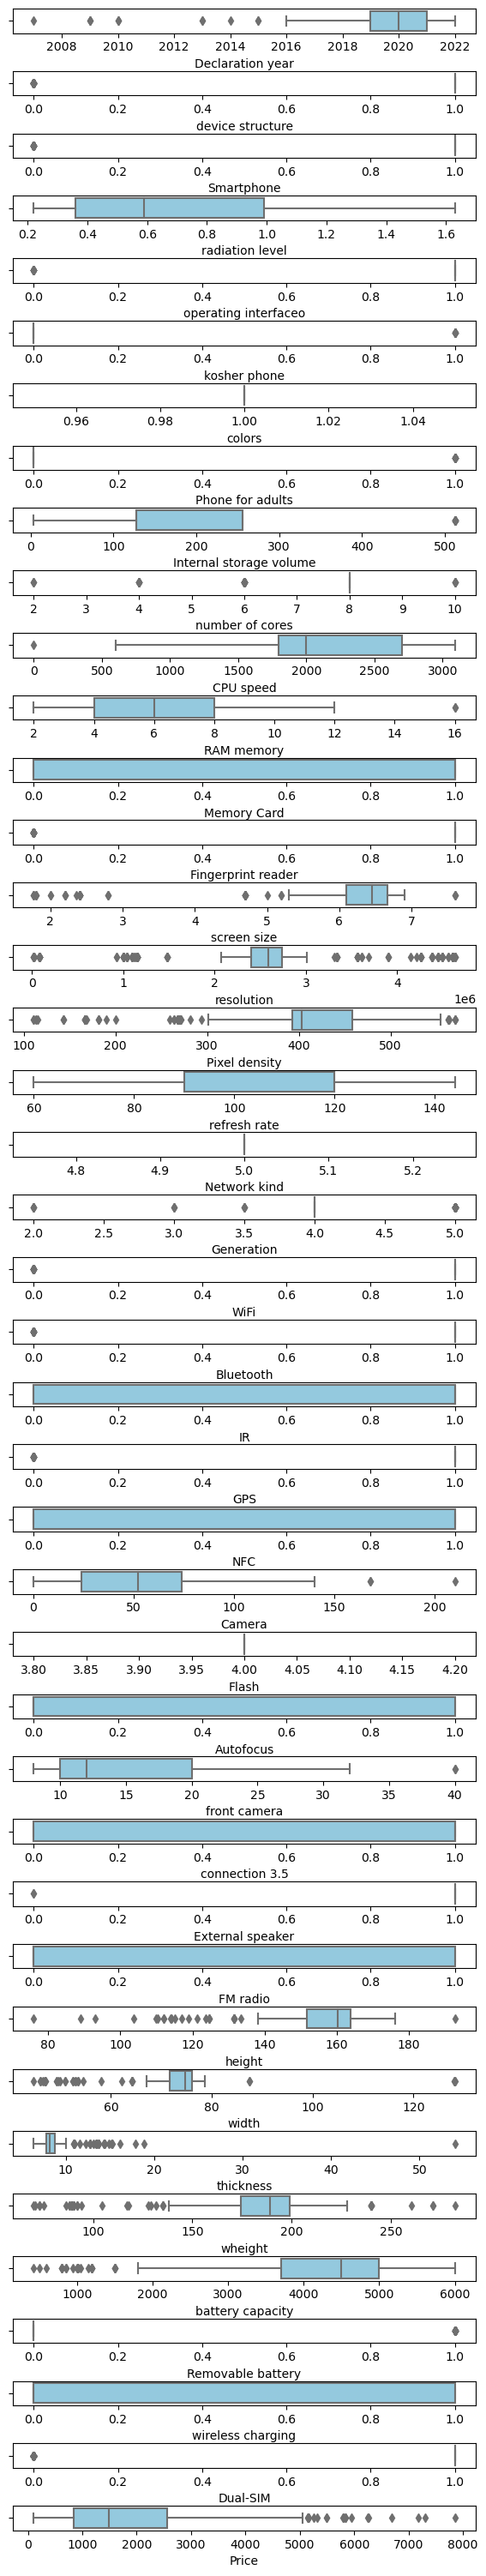

In [143]:
# Depiction of the Numericals variables in a graphical method
cols = NumericalData.columns
fig, ax = plt.subplots(len(cols),1, figsize = (6,30))
plt.tight_layout()
for i , col in enumerate(cols):
    sns.boxplot(data = NumericalData, x = col, ax = ax[i], color = 'skyblue')

We can see that color, Network kind and flash only get one valuem, so we will remove them away.

In [144]:
dfUnionPrice=dfUnionPrice.drop(['colors','Network kind','Flash'],axis=1)

We can see that in the 'CPU speed' column we have one value that equals to 0 and its a clearly outlier.
We need to drop this row. 

In [145]:
dfUnionPrice=dfUnionPrice[(dfUnionPrice['CPU speed'] >1) | (dfUnionPrice['CPU speed'].isnull())]

We will do the same to column - 'thickness' - 'width' - 'front camera' - 'RAM memory'

In [146]:
dfUnionPrice=dfUnionPrice[(dfUnionPrice['thickness'] < 50) | (dfUnionPrice['thickness'].isnull())]
dfUnionPrice=dfUnionPrice[(dfUnionPrice['width'] < 120) | (dfUnionPrice['width'].isnull())]
dfUnionPrice=dfUnionPrice[(dfUnionPrice['front camera'] < 30) | (dfUnionPrice['front camera'].isnull())]
dfUnionPrice=dfUnionPrice[(dfUnionPrice['RAM memory'] < 14) | (dfUnionPrice['RAM memory'].isnull())]
dfUnionPrice=dfUnionPrice[(dfUnionPrice['Camera'] < 150) | (dfUnionPrice['Camera'].isnull())]
dfUnionPrice=dfUnionPrice[(dfUnionPrice['resolution'] >1) | (dfUnionPrice['resolution'].isnull())]
dfUnionPrice=dfUnionPrice[(dfUnionPrice['height'] <180) | (dfUnionPrice['height'].isnull()) |(dfUnionPrice['height'] >100)]

Lets display all our catagoricals in a plt to have a batter information.

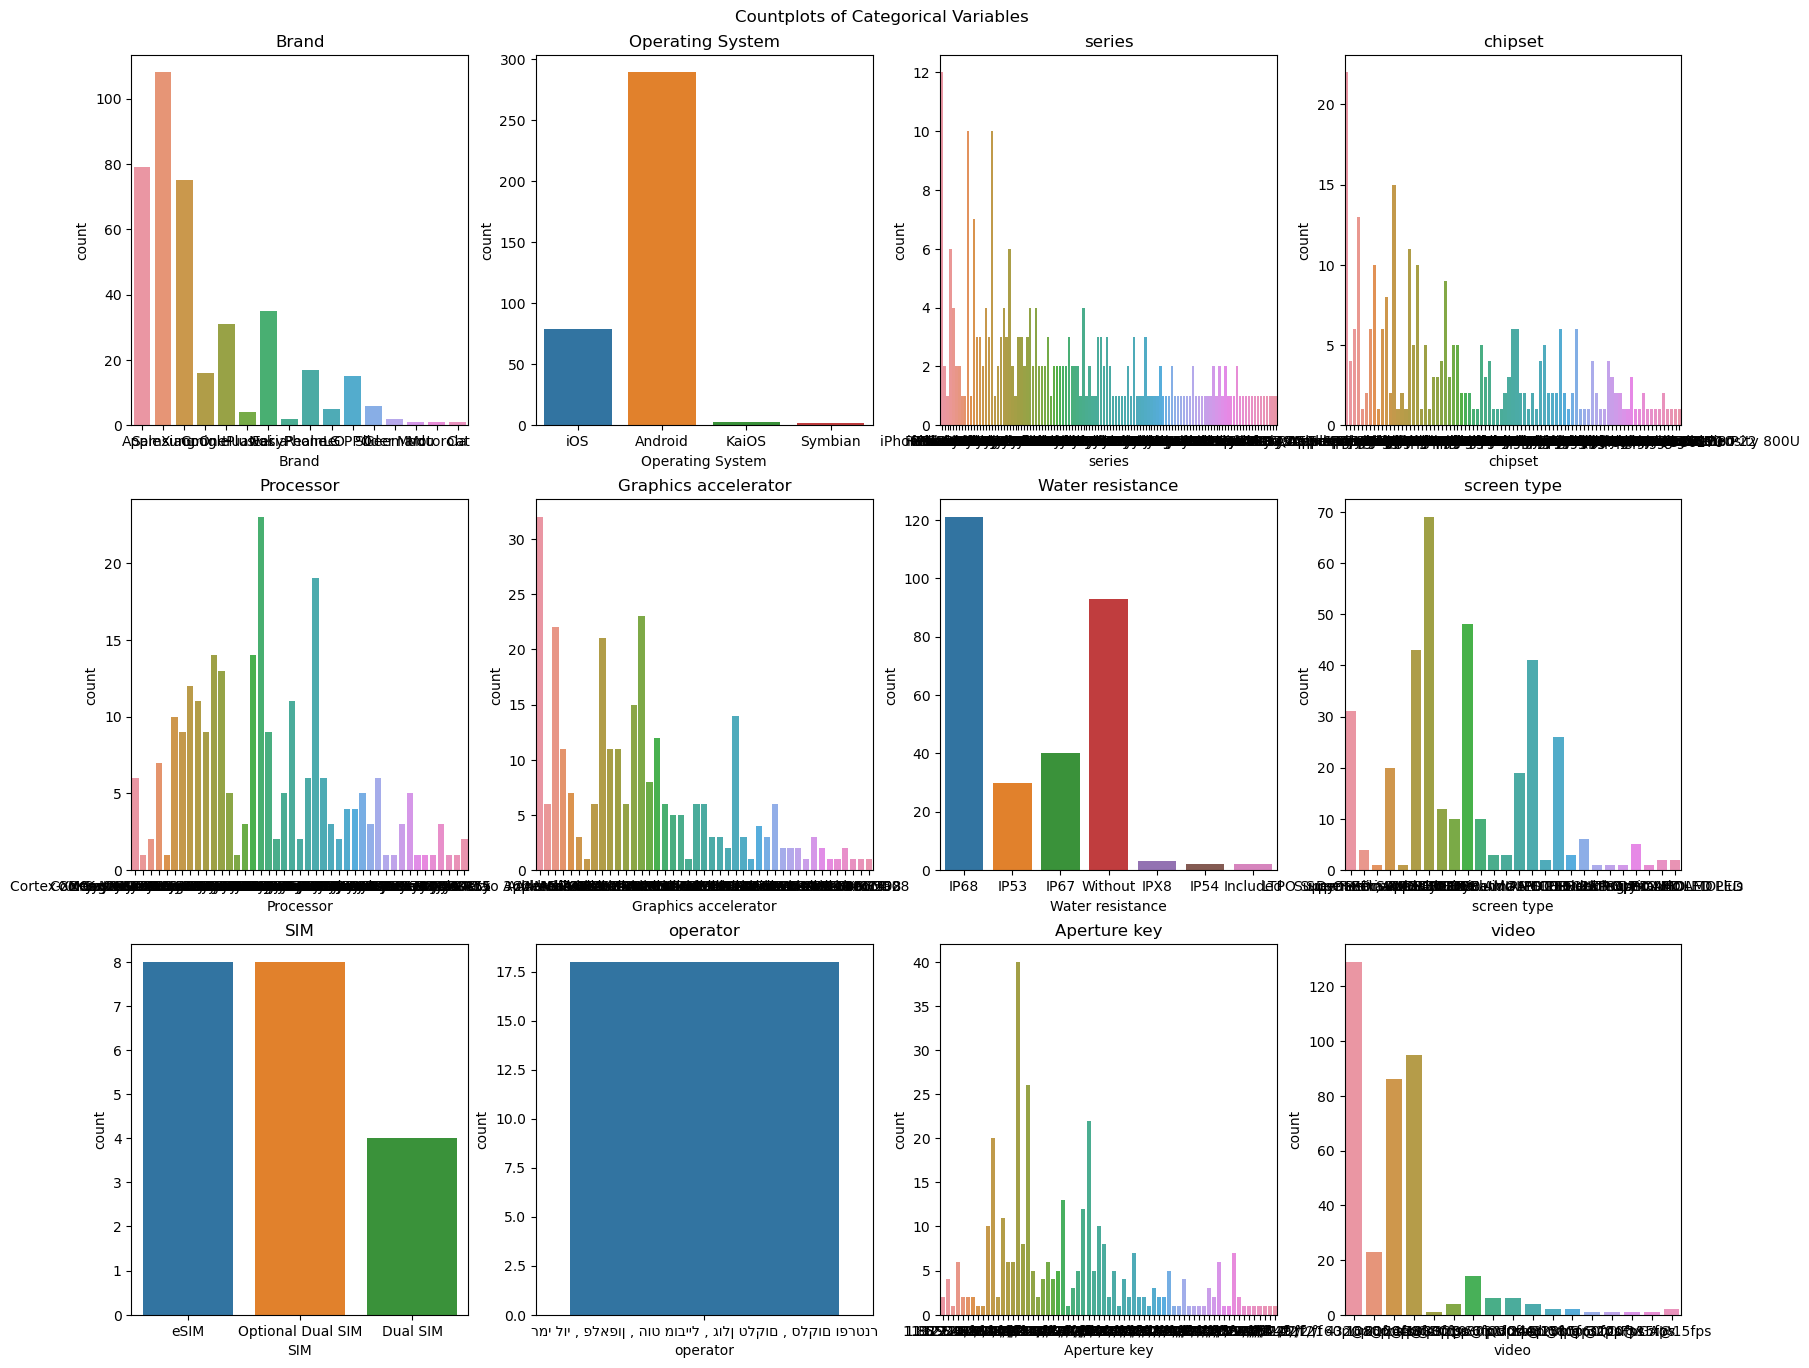

In [147]:
len(Categoricals)
n_plots = len(Categoricals)
n_cols = 4
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 15))
ax = ax.flatten()
for i, col in enumerate(Categoricals):
    sns.countplot(x=dfUnionPrice[col], ax=ax[i])
    ax[i].set_title(col)
plt.subplots_adjust(top=0.95)
plt.suptitle("Countplots of Categorical Variables")
plt.show()


Looks like operator gets the same value for our rows and the ammount of NaN values in this column is huge so we will drop it.

In [148]:
dfUnionPrice=dfUnionPrice.drop(['operator'],axis=1)

Lets check the ammount of NaN valus we have in some of our columns and see if we can save them.

In [149]:
nan_count = dfUnionPrice['SIM'].isnull().sum()
print('The ammount of NaN rows in the SIM column is:',nan_count)

The ammount of NaN rows in the SIM column is: 393


In [150]:
dfUnionPrice.drop('SIM',axis=1,inplace=True)

In [151]:
nan_count = dfUnionPrice['Declaration year'].isnull().sum()
print('The ammount of NaN rows in the Declaration year column is: ',nan_count)

The ammount of NaN rows in the Declaration year column is:  116


This ammout of NaN values is not high as 'SIM' but we still check if we can save them. Therefore lets see it in a plot.

In [152]:
dfUnionPrice['Declaration year'].unique()

array([2021., 2022., 2020., 2019., 2018., 2017.,   nan, 2010., 2015.,
       2013., 2007., 2014., 2009., 2016.])

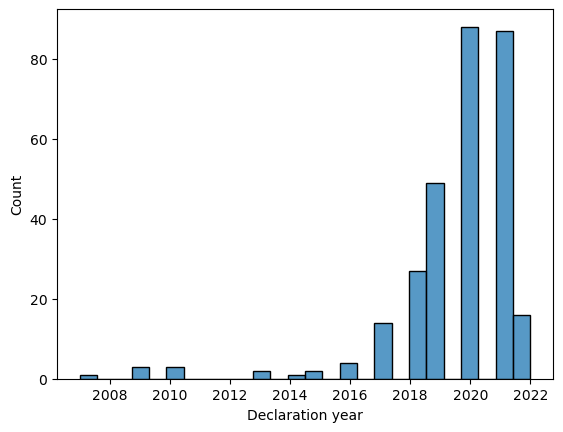

In [153]:
sns.histplot(dfUnionPrice['Declaration year'])
plt.show()

We created a function that will calculate the ammount of each unique values influance according to the ammount of data in a spesific column we will use this function every time that we will see that we got NaN values which we want and can save to stay with the same effect of each unique value on our column. The remain NaN values(a very integer) will get the most common data from the unique values.

In [154]:
def calcolation(Omega,nones,value):
    correntOmega=Omega-nones
    presentage=value/correntOmega
    countOfNaN=presentage*nones
    return int(countOfNaN)


In [155]:
def FillingTheNaN(df,col):
    valuesCount=df[col].unique()
    omega=len(df[col].index)
    numbersToAdd=[]
    numberYear=[]
    nones=nan_count
    for i in valuesCount:
        selected_rows = df.loc[df[col] == i]
        count = selected_rows.shape[0]
        numberYear.append(i)
        numbersToAdd.append(calcolation(omega,nones,count))
    for i in range(len(numbersToAdd)):
        if numbersToAdd[i]>0:
            df[col].fillna(limit=numbersToAdd[i],value=numberYear[i],inplace=True)
    df[col].fillna(df[col].mode()[0],inplace=True)

In [156]:
FillingTheNaN(dfUnionPrice,'Declaration year')


Lets check how it affected:

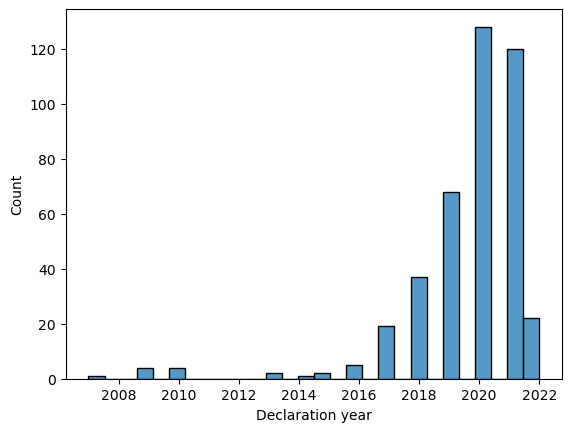

In [157]:

sns.histplot(dfUnionPrice['Declaration year'])
plt.show()

Now you can see that we filled in all the NaN and still kept the relationships between all the years

In [158]:
nan_count = dfUnionPrice['CPU speed'].isnull().sum()
print('The ammount of NaN rows in the CPU speed column is: ',nan_count)

The ammount of NaN rows in the CPU speed column is:  155


Lets do the same to 'CPU speed':

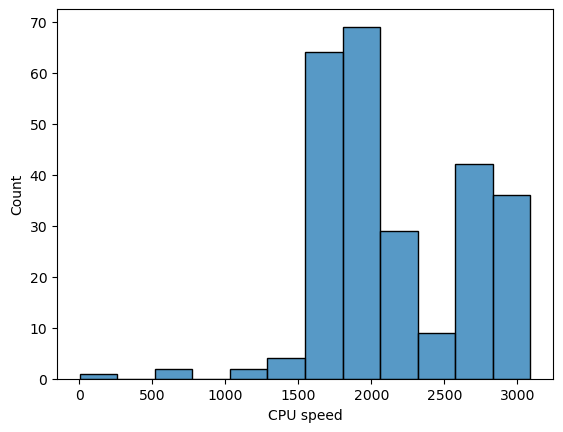

In [159]:
sns.histplot(dfUnionPrice['CPU speed'])
plt.show()


In [160]:
FillingTheNaN(dfUnionPrice,'CPU speed')

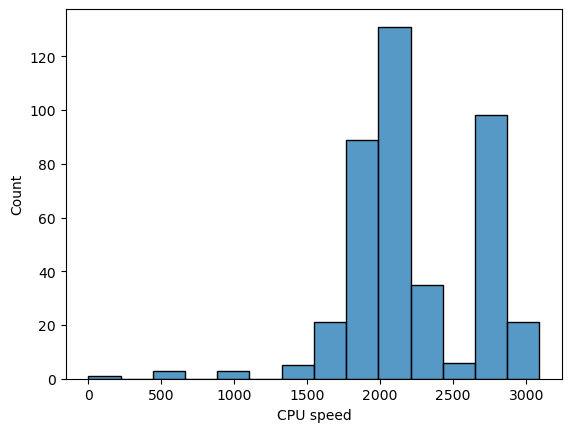

In [161]:
sns.histplot(dfUnionPrice['CPU speed'])
plt.show()

In [162]:
nan_count = dfUnionPrice['front camera'].isnull().sum()
print('The ammount of NaN rows in the front camera column is: ',nan_count)

The ammount of NaN rows in the front camera column is:  392


We have to drop this column accourding to her high ammount of NaN.

In [163]:
dfUnionPrice.drop('front camera',axis=1,inplace=True)

In [164]:
nan_count = dfUnionPrice['number of cores'].isnull().sum()
print('The ammount of NaN rows in the number of cores column is: ',nan_count)

The ammount of NaN rows in the number of cores column is:  130


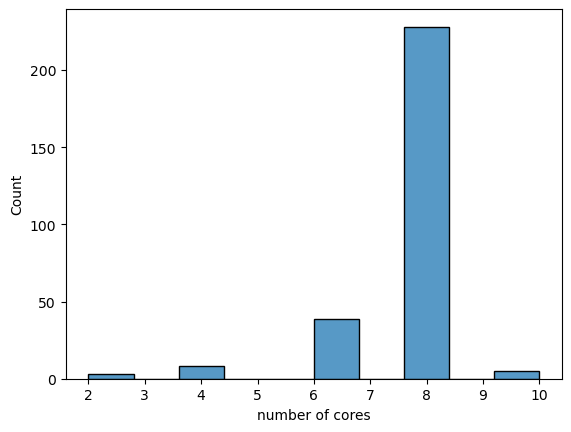

In [165]:
sns.histplot(dfUnionPrice['number of cores'])
plt.show()

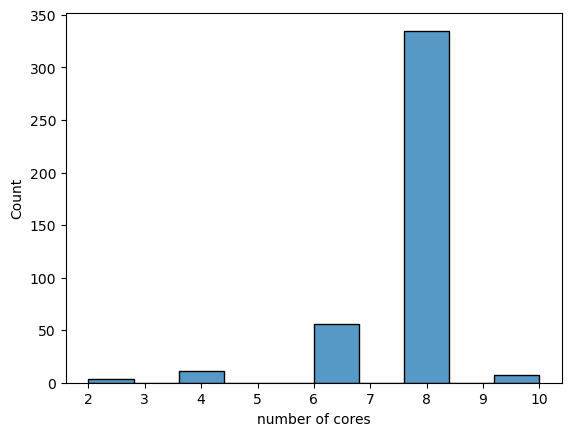

In [166]:
FillingTheNaN(dfUnionPrice,'number of cores')
sns.histplot(dfUnionPrice['number of cores'])
plt.show()

In [167]:
nan_count = dfUnionPrice['refresh rate'].isnull().sum()
print('The ammount of NaN rows in the refresh rate column is: ',nan_count)

The ammount of NaN rows in the refresh rate column is:  245


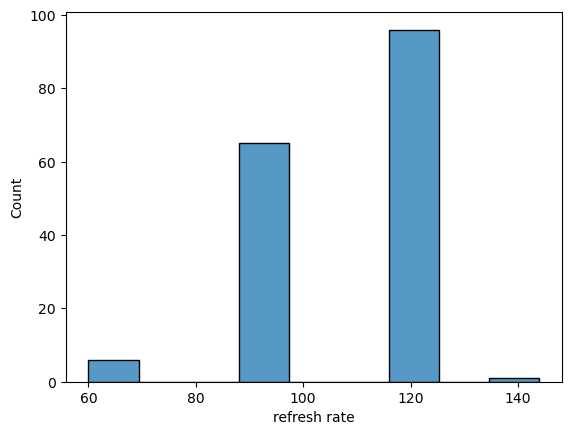

In [168]:
sns.histplot(dfUnionPrice['refresh rate'])
plt.show()

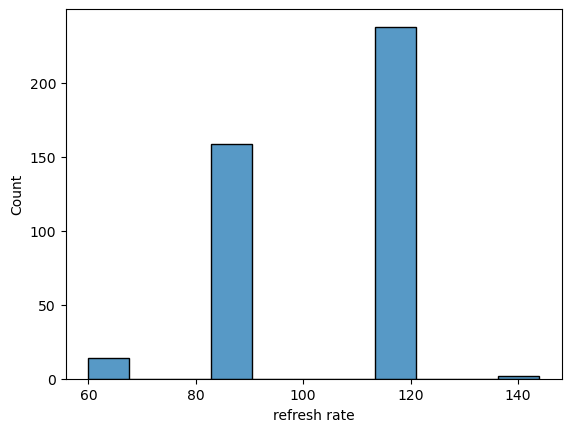

In [169]:
FillingTheNaN(dfUnionPrice,'refresh rate')
sns.histplot(dfUnionPrice['refresh rate'])
plt.show()

In [170]:
nan_count = dfUnionPrice['radiation level'].isnull().sum()
print('The ammount of NaN rows in the radiation level column is: ',nan_count)

The ammount of NaN rows in the radiation level column is:  296


In [171]:
dfUnionPrice.drop('radiation level',axis=1,inplace=True)

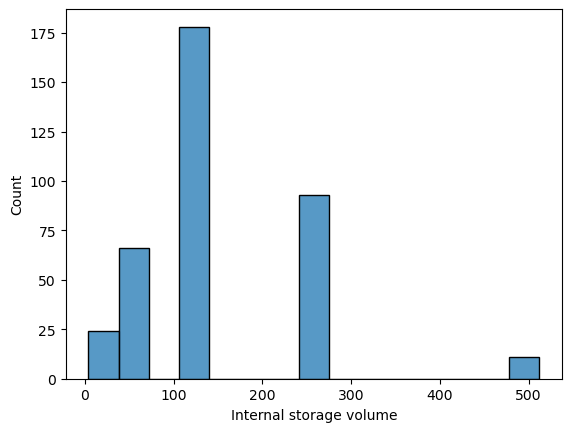

In [172]:
sns.histplot(dfUnionPrice['Internal storage volume'])
plt.show()

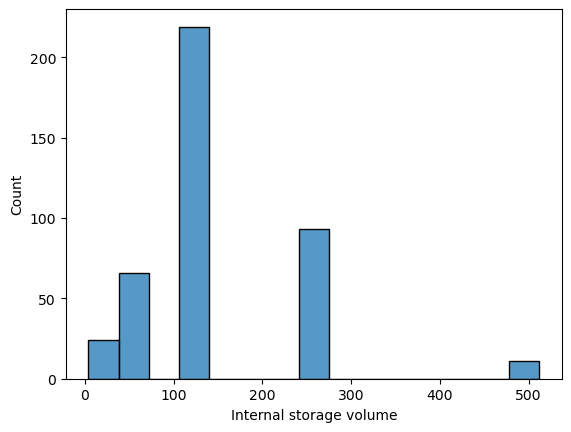

In [173]:
FillingTheNaN(dfUnionPrice,'Internal storage volume')
sns.histplot(dfUnionPrice['Internal storage volume'])
plt.show()

In [174]:
# def create_heatmap(numeric_df):
#     first_col = numeric_df.pop('Price')
#     numeric_df.insert(0, 'Price', first_col)
#     sns.heatmap(numeric_df.corr())
# Numerical,catagoricals=getNumericalsCatagoricals(dfUnionPrice)
# NumericalData=dfUnionPrice[Numerical]
# PhonesHeatmap = NumericalData.select_dtypes(include='number')
# create_heatmap(PhonesHeatmap)

Depiction of the Numericals variables in a graphical method

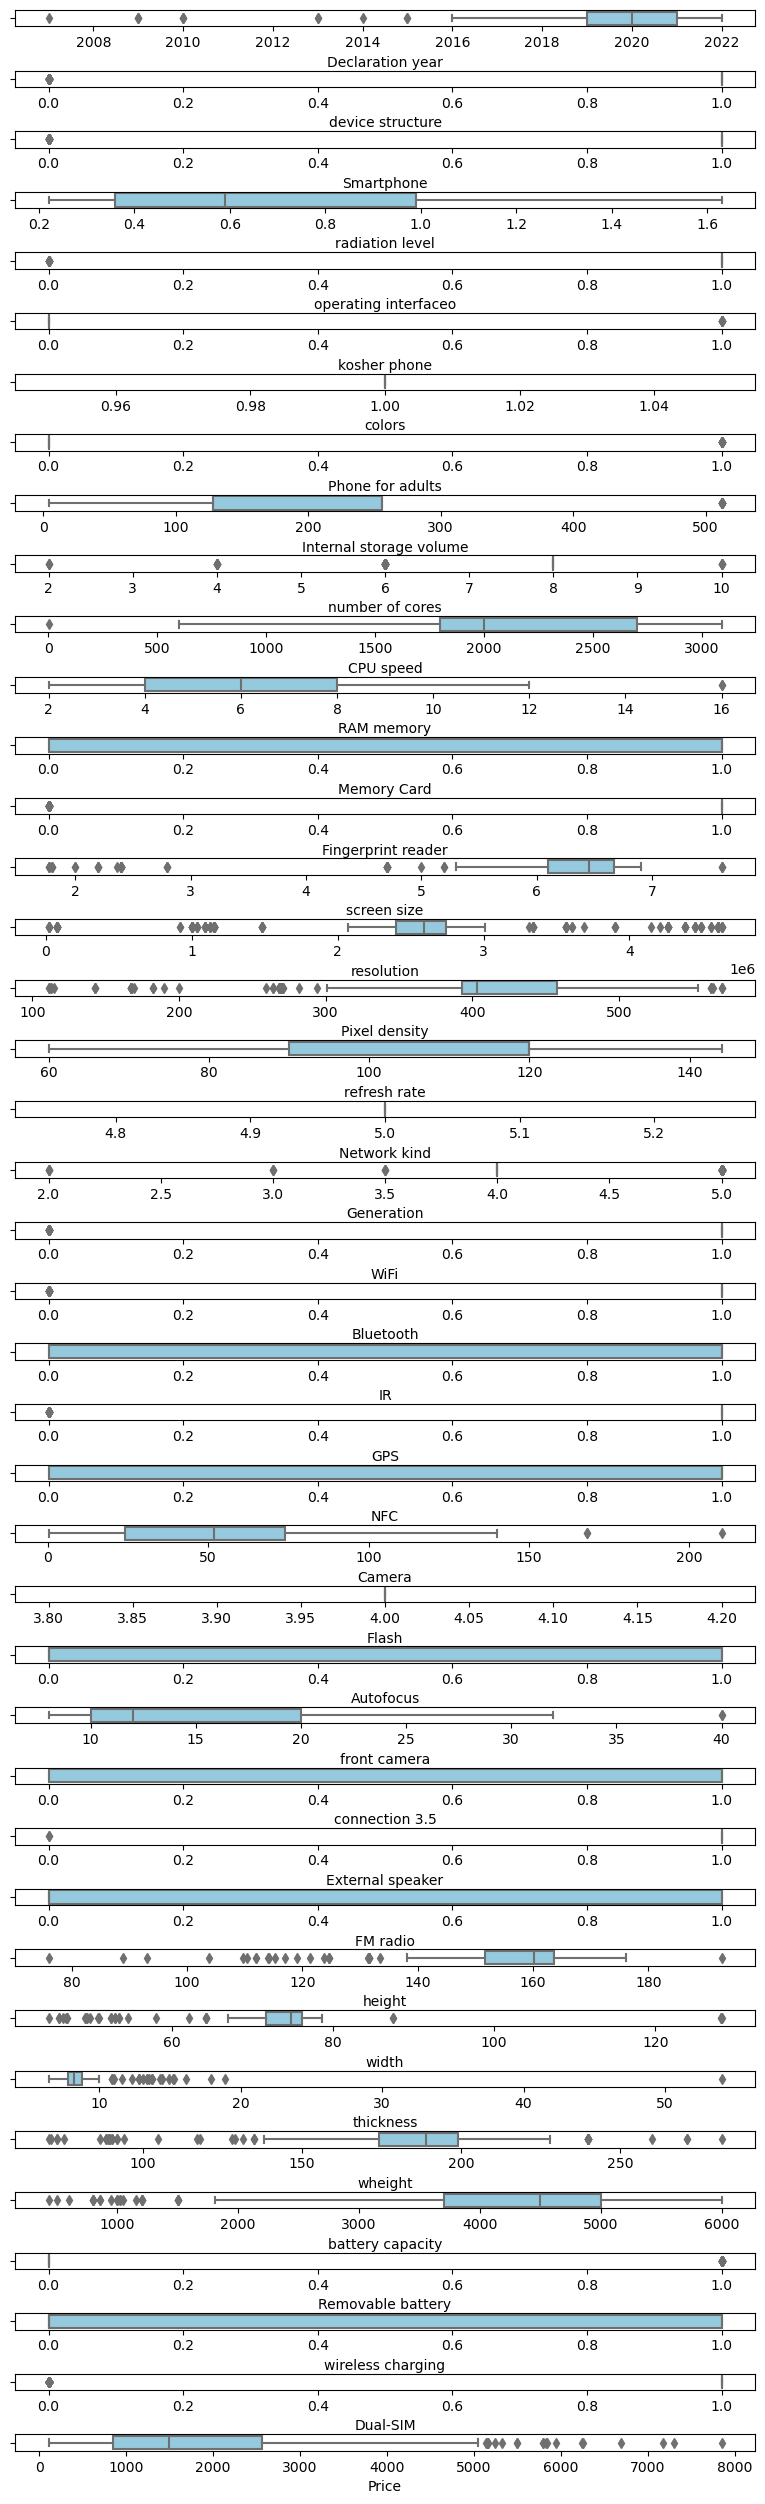

In [175]:
# Depiction of the Numericals variables in a graphical method
Numerical,catagoricals=getNumericalsCatagoricals(dfUnionPrice)
cols = NumericalData.columns
fig, ax = plt.subplots(len(cols),1, figsize = (8,25))
plt.tight_layout()
for i , col in enumerate(cols):
    sns.boxplot(data = NumericalData, x = col, ax = ax[i], color = 'skyblue')

Now lets check all the categorical columns that we got left

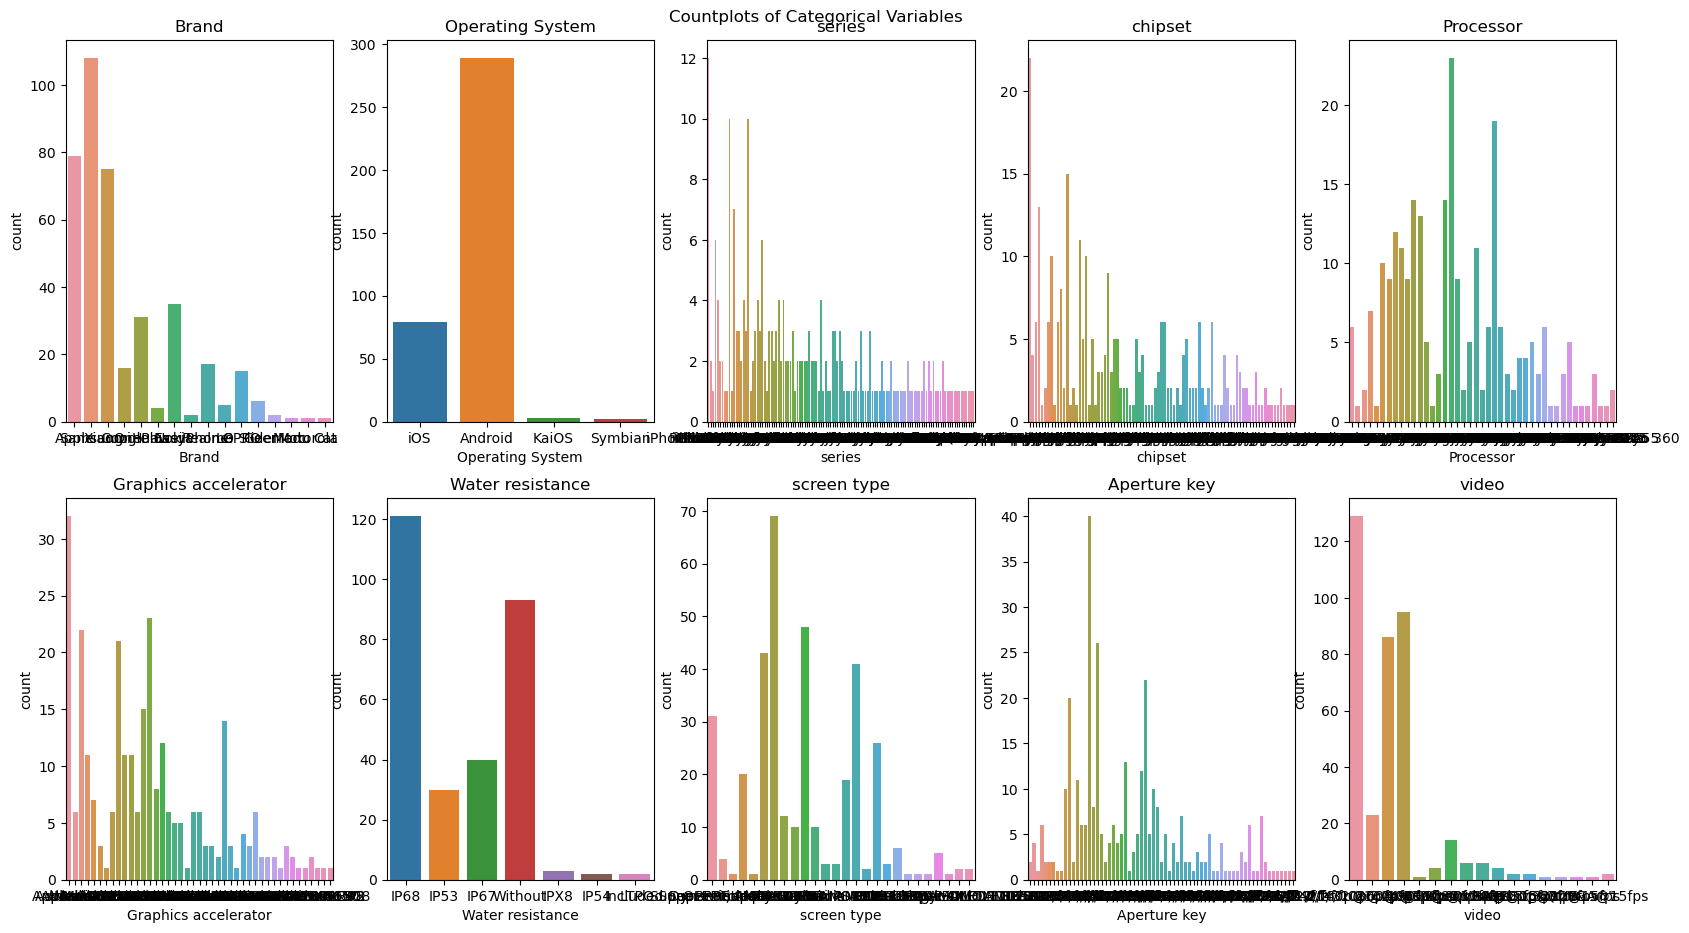

In [176]:
len(catagoricals)
n_plots = len(catagoricals)
n_cols = 5
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 10))
ax = ax.flatten()
for i, col in enumerate(catagoricals):
    sns.countplot(x=dfUnionPrice[col], ax=ax[i])
    ax[i].set_title(col)
plt.subplots_adjust(top=0.95)
plt.suptitle("Countplots of Categorical Variables")
plt.show()


Lets check how the wheight effects on our mean Price:

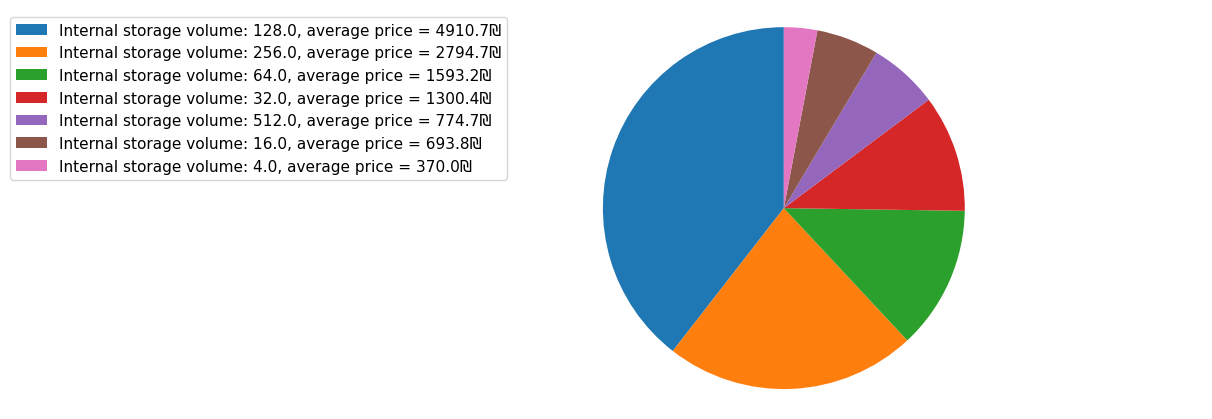

In [177]:
PhonesByProcessor_count = dfUnionPrice['Internal storage volume'].value_counts()

Phone_price_mean_by_Processor= dfUnionPrice.groupby('Internal storage volume', as_index=False)['Price'].mean()
Phone_price_mean_by_Processor.sort_values(by="Price", inplace=True, ascending=False)

labels = ["Internal storage volume: %s" % i for i in PhonesByProcessor_count.index]

fig1, ax1 = plt.subplots(figsize=(12, 4))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(Phone_price_mean_by_Processor['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average price = %1.1f₪' % (
        l, (v)) for l, s, v in zip(labels, Phone_price_mean_by_Processor.index, Phone_price_mean_by_Processor['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

Lets check how the Brand effects on our mean Price:

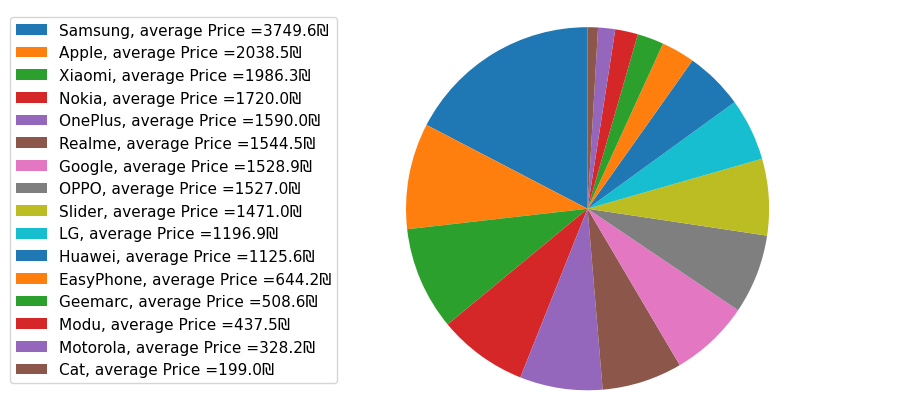

In [178]:
PhonesByProcessor_count = dfUnionPrice['Brand'].value_counts()

Phone_price_mean_by_Processor= dfUnionPrice.groupby('Brand', as_index=False)['Price'].mean()
Phone_price_mean_by_Processor.sort_values(by="Price", inplace=True, ascending=False)

labels = ["%s" % i for i in PhonesByProcessor_count.index]

fig1, ax1 = plt.subplots(figsize=(9, 4))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(Phone_price_mean_by_Processor['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average Price =%1.1f₪' % (
        l, (v)) for l, s, v in zip(labels, Phone_price_mean_by_Processor.index, Phone_price_mean_by_Processor['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

The ammount of NaN before last dropna()

In [179]:
na_cols = dfUnionPrice.isna().sum()
print("Ammount of NaN before dropna:",dfUnionPrice.isna().sum().sum())
sumOfData=dfUnionPrice.shape[0]*dfUnionPrice.shape[1]
print("Ammount of data before dropna:",sumOfData)

Ammount of NaN before dropna: 1458
Ammount of data before dropna: 18998


In [180]:
def the_train_test_func(df):
    triesdf=df.copy()
    triesdf.dropna(inplace=True)
    x=triesdf.drop(["Price"],axis=1)
    y=triesdf['Price']
    X_train,X_test,y_train,y_test= train_test_split(x,y,test_size=0.2,random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    regression=LinearRegression()
    regression.fit(X_train,y_train)
    yPred=regression.predict(X_test)
    print("train:",regression.score(X_train,y_train))
    print("test:",regression.score(X_test,y_test))
    mse=mean_squared_error(y_test,yPred)
    rmse=np.sqrt(mse)
    print("root mean square deviation:",rmse)


Now we want to chcek if we cleaned enough data, so we can predict the price

In [181]:
first_try_df=dfUnionPrice.copy()
first_try_df.dropna(inplace=True)
print("Ammount of data after dropna:",first_try_df.shape[0]*first_try_df.shape[1])
le=LabelEncoder()
first_try_df[catagoricals]=first_try_df[catagoricals].apply(le.fit_transform)
the_train_test_func(first_try_df)


Ammount of data after dropna: 5704
train: 0.8635830812642942
test: 0.7337871503846063
root mean square deviation: 315.49637838395716


In [182]:
first_try_df.shape

(124, 46)

Its seems that we droped a lot of data... 
so we decided to go back to save more data

In [204]:
fix_df=dfUnionPrice.copy()
at_least_1_nan=fix_df.columns[fix_df.isna().any()].tolist()

Okay,lets try to save some of those columns or drop the columns with big amount of nan

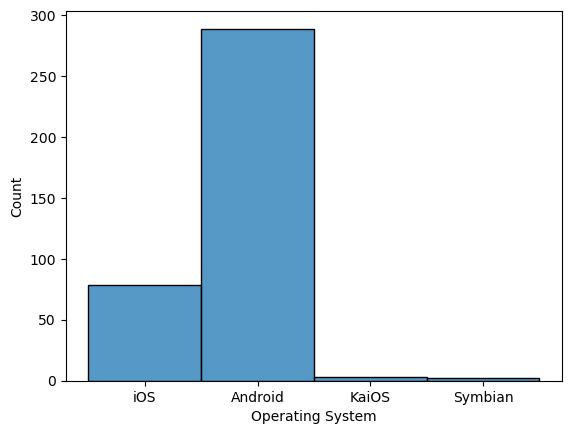

In [205]:
sns.histplot(fix_df['Operating System'])
plt.show()

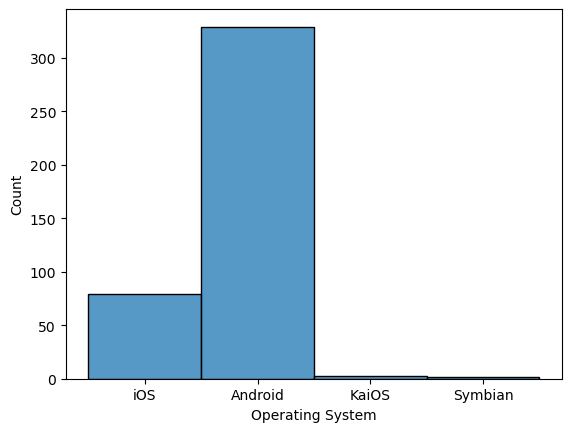

In [206]:
most_freq_operating_system = fix_df['Operating System'].mode()[0]
fix_df['Operating System'] = fix_df['Operating System'].fillna(most_freq_operating_system)
sns.histplot(fix_df['Operating System'])
plt.show()

In [207]:
nan_count = fix_df['battery capacity'].isnull().sum()
print('The ammount of NaN rows in the battery capacity column is: ',nan_count)

The ammount of NaN rows in the battery capacity column is:  82


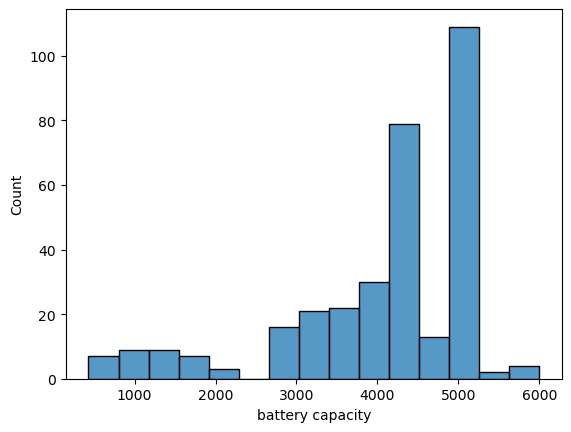

In [208]:
sns.histplot(fix_df['battery capacity'])
plt.show()


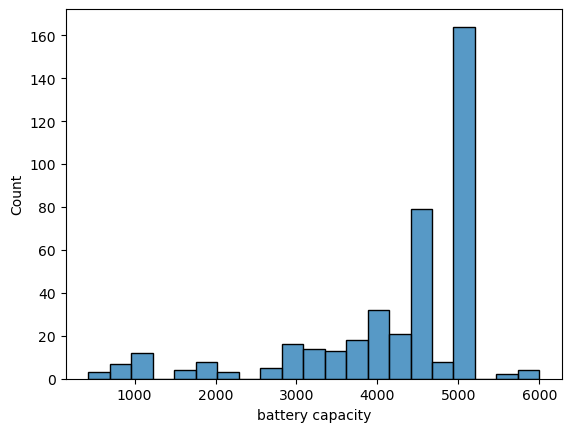

In [209]:
FillingTheNaN(fix_df,'battery capacity')
sns.histplot(fix_df['battery capacity'])
plt.show()

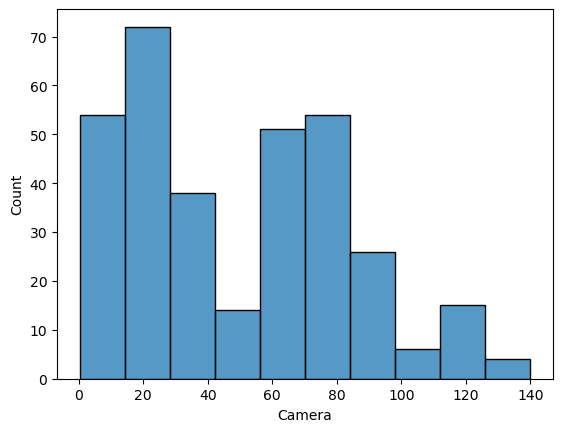

In [210]:
sns.histplot(fix_df['Camera'])
plt.show()

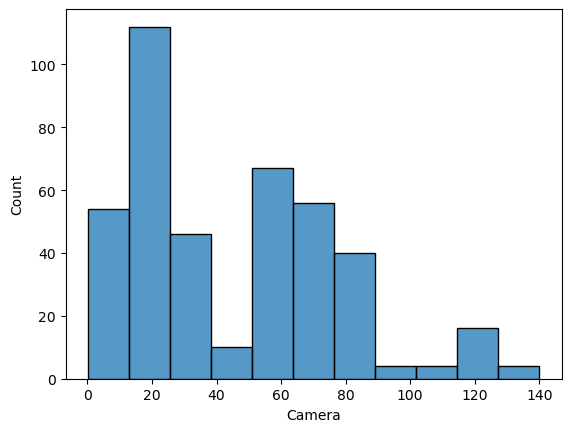

In [211]:
FillingTheNaN(fix_df,'Camera')
sns.histplot(fix_df['Camera'])
plt.show()

In [212]:
series=fix_df['series'].isnull().sum()
chipset=fix_df['chipset'].isnull().sum()
screen_type=fix_df['screen type'].isnull().sum()
Water_resistance=fix_df['Water resistance'].isnull().sum()
Graphics_accelerator=fix_df['Graphics accelerator'].isnull().sum()
Processor=fix_df['Processor'].isnull().sum()
print('NaN count for those rows:\n''series: ',series,'\nscreen_type:',screen_type,'\nWater_resistance:',Water_resistance,'\nGraphics_accelerator:',Graphics_accelerator,'\nProcessor:',Processor,'\nchipset:',chipset)


NaN count for those rows:
series:  176 
screen_type: 48 
Water_resistance: 122 
Graphics_accelerator: 131 
Processor: 165 
chipset: 127


In [213]:
fix_df['screen type'].unique()

array(['Super Retina', 'LTPO Super Retina XDR OLED',
       'Super Retina XDR OLED', 'Dynamic AMOLED 2X',
       'OLED , Super Retina', 'AMOLED', 'Super AMOLED', 'PLS LCD', 'OLED',
       nan, 'IPS', 'Dynamic AMOLED', 'Foldable Dynamic AMOLED 2X',
       'Retina IPS', 'Fluid AMOLED', 'IPS LCD', 'LCD', 'TFT', 'PLS IPS',
       'P-OLED', 'Curved P-OLED', 'PLS', 'Rotating P-OLED', 'LTPO AMOLED',
       'Foldable Dynamic AMOLED', 'Optic AMOLED', 'Super AMOLED Plus'],
      dtype=object)

Its look we have a lot of data in screen type column so we decided not to drop this column but rather to fill the nan with a "junk values"


In [214]:
fix_df['screen type'].fillna("junk values",inplace=True)

In [215]:
fix_df=fix_df.drop(['series','chipset','Processor','Graphics accelerator','Water resistance'],axis=1)
sumOfData=fix_df.shape[0]*fix_df.shape[1]
print("Ammount of data before dropna:",sumOfData)
fix_df.dropna(inplace=True)
sumOfData=fix_df.shape[0]*fix_df.shape[1]
print("Ammount of data after dropna:",sumOfData)


Ammount of data before dropna: 16933
Ammount of data after dropna: 11193


Lets check what was the columns which have the highest correlations with the price.
That mean that when those columns are the same with the price

Operating System


c:\Users\eranb\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


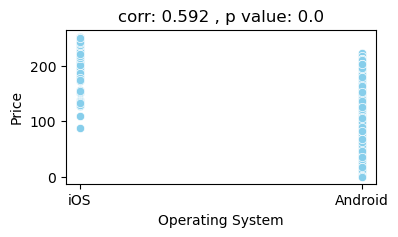

Internal storage volume


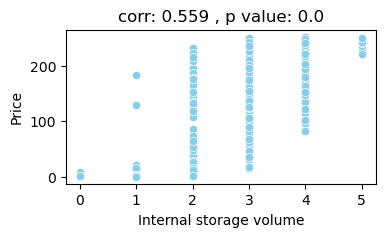

resolution


c:\Users\eranb\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


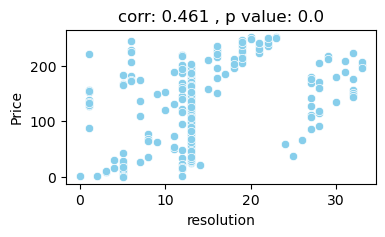

Pixel density


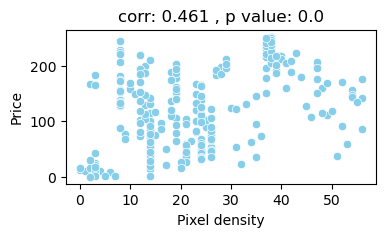

NFC


c:\Users\eranb\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


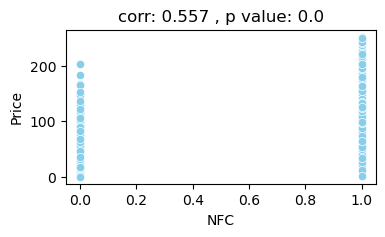

video


c:\Users\eranb\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


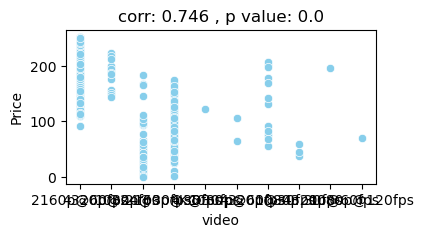

c:\Users\eranb\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


wireless charging


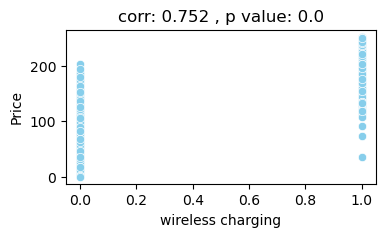

In [216]:
Numerical,catagoricals=getNumericalsCatagoricals(fix_df)
tmp = []
le=LabelEncoder()
fix_df[Numerical]=fix_df[Numerical].apply(le.fit_transform)
var2='Price'
for var1 in fix_df.columns:
    item = list(set([var1, var2]))
    tmp.append((var1, var2))
    corr, p = spearmanr(fix_df[var1], fix_df[var2], nan_policy='omit')
    title = 'corr: ' + str(round(corr,3)) + ' , ' +  'p value: ' + str(round(p,3))
    if corr > 0.4 and corr<0.99:
        plt.figure(figsize=(4,2))
        print(var1)
        sns.scatterplot(data=fix_df, x=var1, y=var2, color='skyblue')
        plt.title(title)
        plt.show()

As we can see the Pixel density, resolution and internal storage volume have the biggest corelation between them to our Price column.

In [220]:
triesdf=fix_df.copy()
label=['Brand','Operating System','screen type','video','Aperture key']
le=LabelEncoder()
triesdf[label]=triesdf[label].apply(le.fit_transform)
the_train_test_func(triesdf)

train: 0.8796877347929348
test: 0.8127996721354426
root mean square deviation: 30.521799521955657


Amazing! we can see that we have a much batter prediction and our price deviation has decreased!


Lets check Pearson correlation coefficient between Price and our Numericals data: 

In [222]:
ref_column = 'Price'
for col in triesdf.columns:
    if col == ref_column:
        continue
    corr, p_value = pearsonr(triesdf[ref_column], triesdf[col])
    if corr>0.4:
        print(f'Pearson correlation coefficient between {ref_column} and {col}: {corr}')
        print(f'p-value between {ref_column} and {col}: {p_value}\n')


Pearson correlation coefficient between Price and Operating System: 0.5923487748936889
p-value between Price and Operating System: 3.019144119282033e-27

Pearson correlation coefficient between Price and Internal storage volume: 0.5681391691855793
p-value between Price and Internal storage volume: 9.795451282770473e-25

Pearson correlation coefficient between Price and resolution: 0.43016228323010963
p-value between Price and resolution: 1.0084949986387847e-13

Pearson correlation coefficient between Price and Pixel density: 0.4678888056973498
p-value between Price and Pixel density: 2.9488789680760414e-16

Pearson correlation coefficient between Price and NFC: 0.5578091527705282
p-value between Price and NFC: 1.0021146812596219e-23

Pearson correlation coefficient between Price and video: 0.6615100332156796
p-value between Price and video: 9.865185032712292e-36

Pearson correlation coefficient between Price and wireless charging: 0.7522015968349309
p-value between Price and wireless c

c:\Users\eranb\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


This correlation coefficient and p-value suggest that there is a strong positive correlation between the price of a product and  operating system,Internal storage volume,NFC,video and wireless charging  it uses, and this correlation is statistically significant.